In [49]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from statsmodels.tsa.arima_model import ARIMA

def parser(x):
    return datetime.strptime(x, '%Y-%m')

data = pd.read_csv('co2-ppm-mauna-loa-19651980.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
ts = data
ts_log = np.log(ts)

In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #  Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

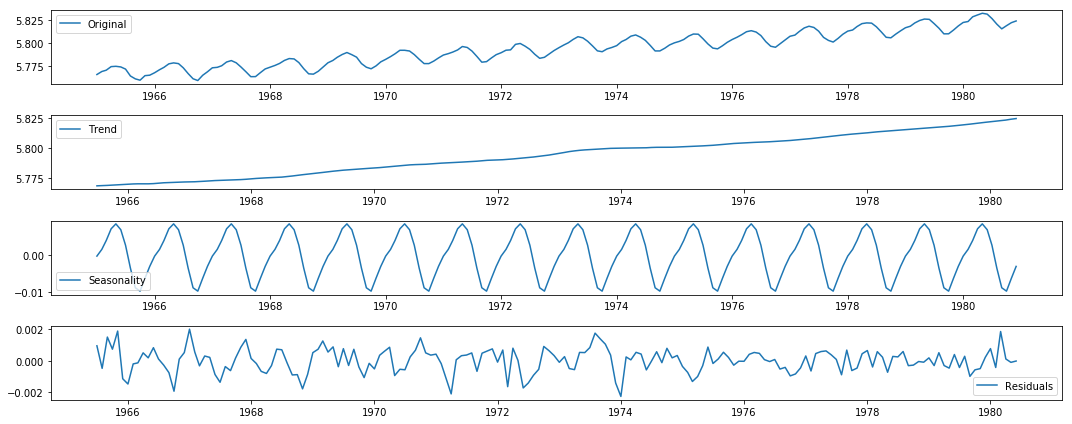

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [70]:
train_interval = range(0,int(len(ts_log)*0.667))
test_interval = range(int(len(ts_log)*0.667), len(ts_log))

In [71]:
# ts_log_train = ts_log[train_interval]
ts_log_train = ts_log
ts_log_test = ts_log[test_interval]

ts_log_diff = ts_log_train - ts_log_train.shift()
# plt.plot(ts_log_diff)

In [72]:
ts_log_diff.dropna(inplace=True)
# test_stationarity(ts_log_diff)

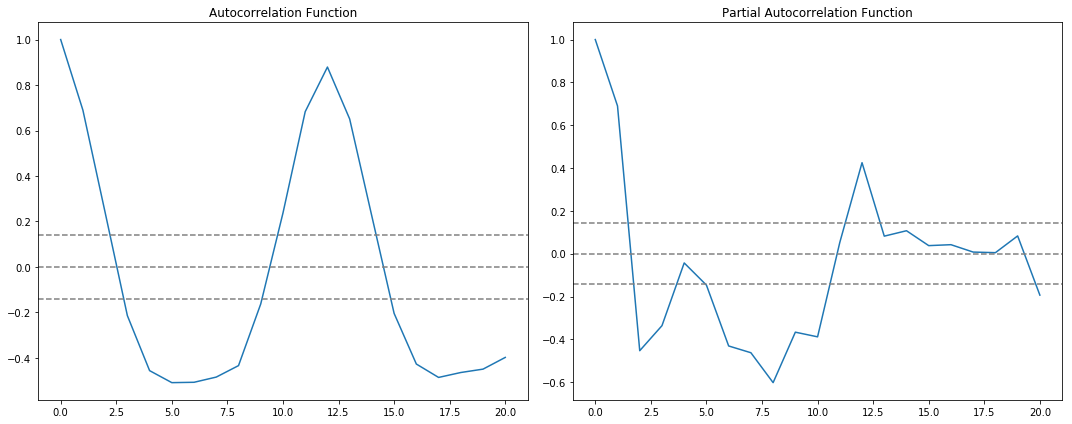

In [42]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/home/anshul/anaconda2/envs/voice/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/anshul/anaconda2/envs/voice/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


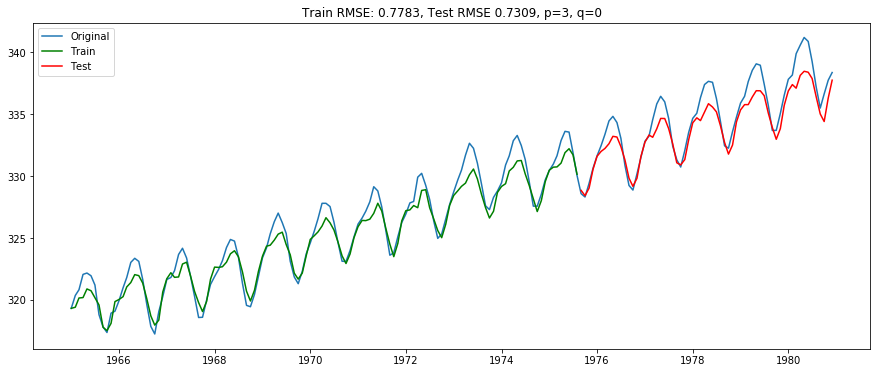

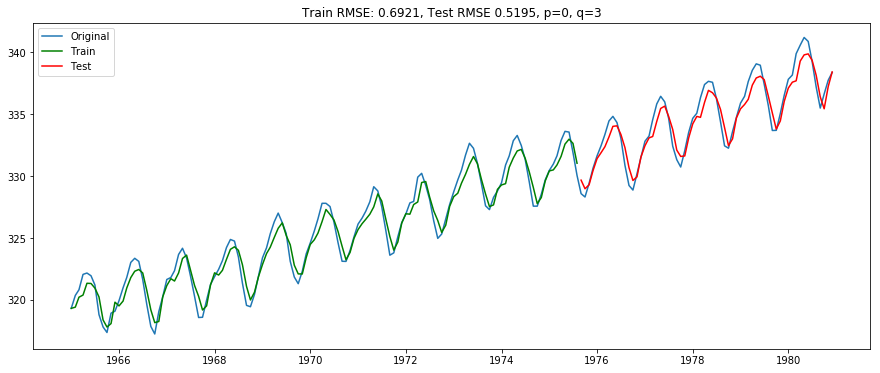

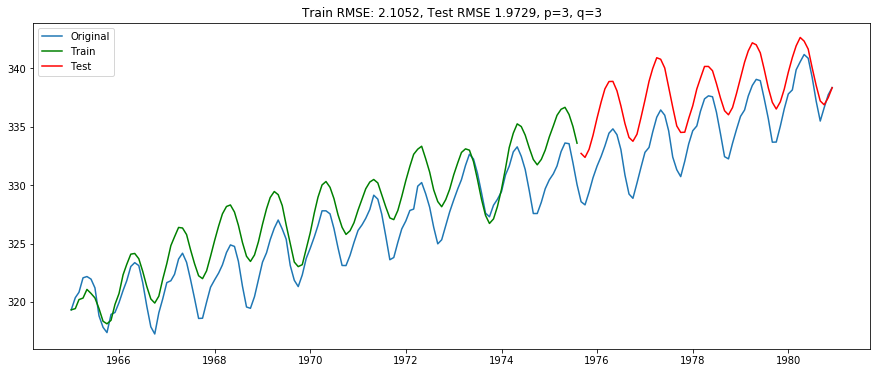

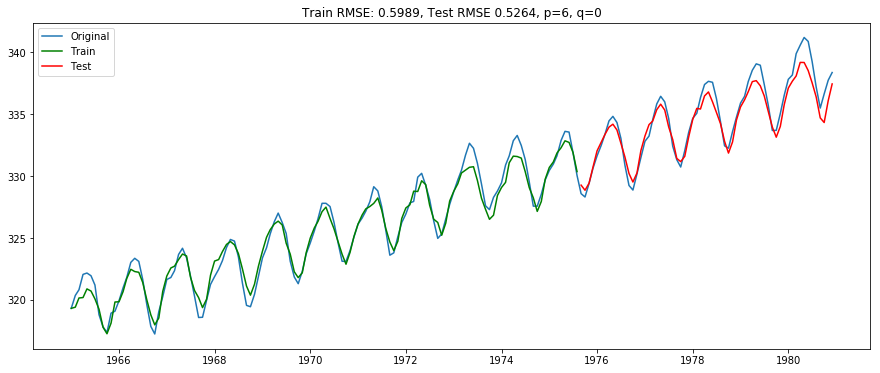

In [95]:
order_list = [(3, 1, 0),(0, 1, 3),(3, 1, 3),(6,1,0)]
results_ARIMA_list = list()
for i,order in enumerate(order_list):
    model = ARIMA(ts_log_train, order=order)
#     results_ARIMA_list.append(model.fit(disp=-1))
    results_ARIMA = model.fit(disp=-1)
#     plt.plot(ts_log_diff)
#     plt.plot(results_ARIMA.fittedvalues, color='red')
#     plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
    predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
    predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
    predictions_ARIMA_log_train = predictions_ARIMA_log[train_interval]
    predictions_ARIMA_log_test = predictions_ARIMA_log[test_interval]
    
    predictions_ARIMA_train = np.exp(predictions_ARIMA_log_train)
    predictions_ARIMA_test = np.exp(predictions_ARIMA_log_test)
    plt.figure(i)
    plt.plot(ts,label='Original')
    plt.plot(predictions_ARIMA_train,color = 'green', label='Train')
    plt.plot(predictions_ARIMA_test,color = 'red', label='Test')
    plt.legend(loc='best')
    train_error = np.sqrt(sum((predictions_ARIMA_train-ts[train_interval])**2)/len(ts))
    test_error = np.sqrt(sum((predictions_ARIMA_test-ts[test_interval])**2)/len(ts))
    plt.title('Train RMSE: %.4f, Test RMSE %.4f, p=%d, q=%d'%(train_error, test_error, order[0], order[2]))
    
# print len(results_ARIMA_list)